## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v9

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
#print('hej')

2.2.0
C:\Users\PC\AppData\Local\Temp\tmpe7tbfhr0\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


### Dropping ETFS and market indices

In [3]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [4]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [5]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [6]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [8]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

# Investigating return characteristics.

In [9]:
from scipy.stats import kurtosis,skew,spearmanr,kendalltau

In [10]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

In [37]:
for i,ticker in enumerate(data.Ticker.unique()):
    
    ## Price series
    temp_price = data[data.Ticker==ticker].close
    
    ## Returns
    simple_ticker_returns = (temp_price.values[1:]/temp_price.values[:-1]) - 1
    log_ticker_returns = np.log(temp_price.values[1:]) - np.log(temp_price.values[:-1])
    
    ##### Autocorrelations
    ## Pearsons
    autocorr_log = np.correlate(log_ticker_returns,
                                log_ticker_returns,
                                mode='full')
    autocorr_log = autocorr_log[autocorr_log.size//2:]
    autocorr_simple = np.correlate(simple_ticker_returns,
                                   simple_ticker_returns,
                                   mode='full')
    autocorr_simple = autocorr_simple[autocorr_simple.size//2:]
    
    ## Spearmans
    s_auto_log,p_val_l = spearmanr(log_ticker_returns[0:-1],log_ticker_returns[1:])
    s_auto_simple,p_val_s = spearmanr(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    ## Kendalls
    k_auto_log,pval_l = kendalltau(log_ticker_returns[0:-1],log_ticker_returns[1:])
    k_auto_simple,pval_s = kendalltau(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    
    if i == 0:
        simple_returns = pd.DataFrame()
        log_returns = pd.DataFrame()
        additional_simple = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                                  'P_val_S','Corr_K','P_val_K','Avg spread'])
        additional_log = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                               'P_val_S','Corr_K','P_val_K','Avg spread'])
        
        returns = pd.DataFrame({'simple_returns':simple_ticker_returns,
                                'log_returns':log_ticker_returns})
        returns['ticker'] = ticker
    else:
        temp = pd.DataFrame({'simple_returns':simple_ticker_returns,
                             'log_returns':log_ticker_returns})
        temp['ticker'] = ticker
        returns = pd.concat([returns,temp])
    
    simple_returns.loc[:,ticker] = simple_ticker_returns
    log_returns.loc[:,ticker] = log_ticker_returns
    
    additional_simple.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                                  'P_val_S','Corr_K','P_val_K','Avg spread']] = [kurtosis(simple_ticker_returns),
                                                                                 skew(simple_ticker_returns),
                                                                                 autocorr_simple[0],
                                                                                 s_auto_simple,
                                                                                 p_val_s,
                                                                                 k_auto_simple,
                                                                                 pval_s,
                                                                                 np.mean(data[data.Ticker==ticker].spread_close/temp_price)]
    additional_log.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                               'P_val_S','Corr_K','P_val_K','Avg spread']] = [kurtosis(log_ticker_returns),
                                                                             skew(log_ticker_returns),
                                                                             autocorr_log[0],
                                                                              s_auto_simple,
                                                                              p_val_s,
                                                                              k_auto_simple,
                                                                              pval_s,
                                                                              np.mean(data[data.Ticker==ticker].spread_close/temp_price)]
#         simple_returns = (data.close.values[1:]/data.close.values[0:-1])-1
# log_returns = np.log(data.close.values[1:]) - np.log(data.close.values[0:-1])

In [12]:
simple_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SO,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT
0,-0.000830,0.009258,0.000000,-0.001213,0.002533,0.012747,0.003688,0.001373,-0.002990,0.000000,...,-0.001787,0.000907,-0.000651,0.000452,-0.005694,0.002102,-0.004591,0.003867,0.002202,0.000372
1,-0.001522,-0.005810,-0.000548,-0.001518,0.006808,0.005124,-0.007838,-0.001066,0.002142,0.000128,...,0.000000,-0.002924,-0.001792,0.002095,0.001372,0.001144,0.003491,-0.000268,0.001969,0.002767
2,0.001785,0.001968,-0.000055,-0.007052,0.000085,-0.004875,0.009875,-0.000991,0.000427,0.000898,...,-0.006715,-0.006361,-0.002285,0.000164,0.007326,0.000381,-0.000064,-0.001659,0.001993,-0.000782
3,0.004237,0.001166,0.000110,-0.000245,-0.002573,-0.004876,-0.005483,0.001043,-0.000641,0.000641,...,-0.003606,-0.000624,-0.002454,-0.001639,0.008208,0.000000,0.001149,0.000268,0.001307,-0.000206
4,-0.000809,-0.000552,-0.000713,-0.000980,0.001258,-0.001174,-0.001791,-0.000661,-0.001924,0.000640,...,0.000905,-0.003702,-0.002952,-0.001560,-0.001427,-0.003618,-0.002264,-0.004556,0.001901,0.002267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.000486,0.003576,0.002354,0.001579,0.001414,0.001094,-0.000789,0.001865,-0.002474,0.001061,...,0.001835,0.001621,0.003894,0.000674,0.001716,-0.000791,-0.000470,0.000350,0.000357,0.001210
7795,-0.000783,0.002106,0.003203,0.000292,0.000387,0.000206,-0.000309,-0.000991,0.000827,-0.000848,...,0.000000,0.000118,0.000323,0.000317,-0.000479,-0.000396,-0.000206,0.000050,-0.000969,-0.000846
7796,0.001929,-0.000700,0.002554,-0.001051,0.000715,-0.000598,0.000756,0.001210,-0.001239,0.000212,...,-0.001396,-0.000750,-0.001939,-0.000119,-0.001858,0.000792,-0.000294,-0.000300,0.000306,0.002742
7797,-0.002457,0.001240,0.001486,-0.000409,-0.001487,0.000103,0.001064,0.000072,0.001654,0.000212,...,0.000000,0.000277,0.000324,-0.000991,0.001549,-0.001781,0.000029,-0.000599,0.000000,-0.002091


In [13]:
log_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SO,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT
0,-0.000830,0.009216,0.000000,-0.001213,0.002530,0.012666,0.003681,0.001372,-0.002994,0.000000,...,-0.001789,0.000906,-0.000652,0.000452,-0.005710,0.002100,-0.004602,0.003860,0.002199,0.000372
1,-0.001524,-0.005827,-0.000548,-0.001519,0.006785,0.005111,-0.007869,-0.001067,0.002139,0.000128,...,0.000000,-0.002928,-0.001794,0.002093,0.001371,0.001144,0.003485,-0.000268,0.001967,0.002763
2,0.001783,0.001966,-0.000055,-0.007077,0.000085,-0.004887,0.009827,-0.000992,0.000427,0.000897,...,-0.006738,-0.006381,-0.002288,0.000164,0.007300,0.000381,-0.000064,-0.001661,0.001991,-0.000783
3,0.004228,0.001166,0.000110,-0.000245,-0.002576,-0.004888,-0.005498,0.001043,-0.000641,0.000640,...,-0.003612,-0.000624,-0.002457,-0.001641,0.008175,0.000000,0.001149,0.000268,0.001306,-0.000206
4,-0.000810,-0.000552,-0.000713,-0.000980,0.001257,-0.001175,-0.001793,-0.000661,-0.001926,0.000640,...,0.000904,-0.003709,-0.002957,-0.001561,-0.001428,-0.003624,-0.002266,-0.004566,0.001900,0.002265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.000486,0.003570,0.002352,0.001578,0.001413,0.001094,-0.000789,0.001863,-0.002477,0.001061,...,0.001834,0.001620,0.003887,0.000674,0.001715,-0.000791,-0.000470,0.000350,0.000357,0.001209
7795,-0.000784,0.002104,0.003198,0.000292,0.000387,0.000206,-0.000309,-0.000992,0.000826,-0.000849,...,0.000000,0.000118,0.000323,0.000317,-0.000479,-0.000396,-0.000206,0.000050,-0.000970,-0.000846
7796,0.001927,-0.000701,0.002551,-0.001051,0.000715,-0.000598,0.000755,0.001209,-0.001240,0.000212,...,-0.001397,-0.000750,-0.001941,-0.000119,-0.001860,0.000792,-0.000294,-0.000300,0.000306,0.002738
7797,-0.002460,0.001239,0.001485,-0.000409,-0.001488,0.000103,0.001063,0.000072,0.001653,0.000212,...,0.000000,0.000276,0.000324,-0.000991,0.001548,-0.001782,0.000029,-0.000599,0.000000,-0.002093


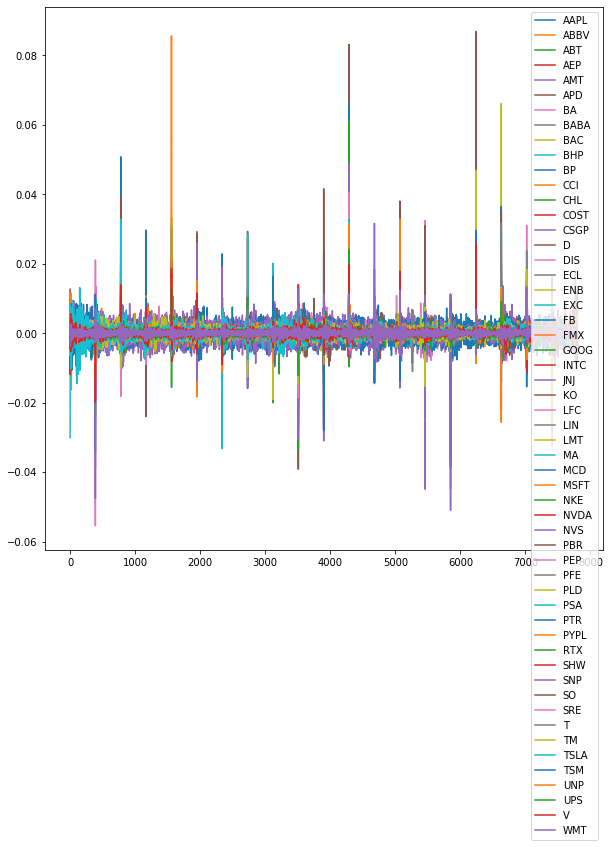

In [14]:
log_returns.plot(figsize=(10,10))
plt.show()

In [15]:
threshold = 0.05

for ticker in log_returns.columns:
    
    if log_returns[log_returns.loc[:,ticker]>threshold].shape[0]>0:
        print(ticker)

BA
BAC
BHP
BP
DIS
PBR
PTR
PYPL
RTX


In [16]:
outliers = data[(data.Ticker=='BA')].close.values[1:][(log_returns.loc[:,'BA']>threshold)]
outliers

array([126.425, 144.675])

In [17]:
data[data.close.isin(outliers)]

open     high      low    close  spread_open  spread_high  \
20200505 355  126.465  126.515  126.370  126.425         0.05         0.06   
20200506 41   126.300  126.425  126.150  126.425         0.06         0.13   
20200507 18   126.050  126.425  126.020  126.425         0.08         0.36   
20200508 87   144.600  144.705  144.510  144.675         0.02         0.10   
20200512 359  126.535  126.615  126.405  126.425         0.05         0.21   
         153  144.760  144.820  144.595  144.675         0.02         0.08   
         175  144.705  144.735  144.660  144.675         0.05         0.06   
20200518 0    126.295  126.710  126.085  126.425         0.21         0.64   
20200519 378  126.355  126.590  126.275  126.425         0.09         0.25   
20200526 0    145.150  145.340  144.250  144.675         0.30         0.85   
         90   126.335  126.485  126.335  126.425         0.09         0.20   
20200527 72   144.930  145.305  144.630  144.675         0.06         0.57   
20200528 74   126.290  126.550  126.290  126.425         0.26         0.41   
         93   126.440  126.475  126.405  126.425         0.06         0.12   
         119  126.220  126.455  126.210  126.425         0.28         0.30   
20200529 40   126.445  126.445  126.300  126.425         0.31         0.38   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200505 355        0.01          0.03           4.0           5.0   
20200506 41         0.01          0.05           1.0           4.0   
20200507 18         0.01          0.05           1.0           6.0   
20200508 87         0.01          0.03           3.0           7.0   
20200512 359        0.01          0.13           2.0           5.0   
         153        0.01          0.03           1.0           5.0   
         175        0.01          0.03           2.0          11.0   
20200518 0          0.01          0.15           1.0           6.0   
20200519 378        0.03          0.17           1.0           4.0   
20200526 0          0.01          0.09           2.0          12.0   
         90         0.04          0.07           1.0           2.0   
20200527 72         0.01          0.21           1.0          13.0   
20200528 74         0.07          0.23           4.0           5.0   
         93         0.05          0.07           1.0           1.0   
         119        0.04          0.13           2.0           4.0   
20200529 40         0.07          0.31           1.0           1.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200505 355          1.0            1.0           5.0          11.0   
20200506 41           1.0            3.0           3.0           3.0   
20200507 18           1.0            2.0           1.0          10.0   
20200508 87           1.0            3.0           1.0           4.0   
20200512 359          1.0            1.0           1.0           4.0   
         153          1.0            2.0           1.0          10.0   
         175          1.0            7.0           5.0          10.0   
20200518 0            1.0            2.0          10.0          10.0   
20200519 378          1.0            2.0           1.0           4.0   
20200526 0            1.0            1.0           1.0          13.0   
         90           1.0            1.0           2.0           5.0   
20200527 72           1.0            3.0           6.0          13.0   
20200528 74           1.0            5.0           1.0           4.0   
         93           1.0            1.0           1.0           2.0   
         119          1.0            1.0           1.0           3.0   
20200529 40           1.0            1.0           1.0           4.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200505 355          1.0            1.0   PYPL  Financial Services  
20200506 41           1.0            2.0   PYPL  Financial Services  
20200507 18           1.0            1.0     BA         Industri

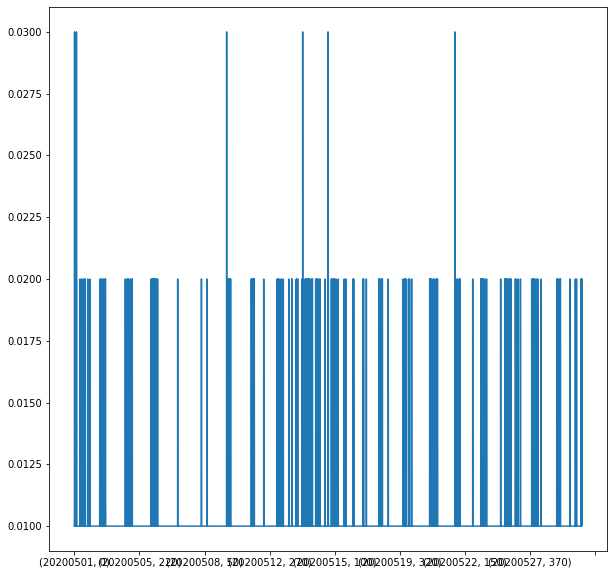

In [18]:
data[data.Ticker=='BP'].spread_close.plot(figsize=(10,10))
plt.show()

In [21]:
# pd.Series(simple_returns).describe()
simple_returns.describe().T.reset_index().merge(additional_simple.reset_index(),
                                                on = 'index',how='left')

,index,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skewness,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread
0,AAPL,7799.0,1.249377e-05,0.000872,-0.023013,-0.000354,0.000016,0.000370,0.016849,113.266,0.49655,0.00593174,0.0288134,0.0109426,0.019875,0.00849631,0.000122323
1,ABBV,7799.0,1.791648e-05,0.001133,-0.009848,-0.000486,0.000000,0.000494,0.027989,106.828,4.62043,0.0100121,0.00774261,0.494214,0.00540149,0.474948,0.000307928
2,ABT,7799.0,5.791693e-06,0.000936,-0.011681,-0.000418,0.000000,0.000425,0.022755,79.0232,2.58814,0.0068298,-0.0111588,0.324495,-0.00814725,0.281392,0.000382299
3,AEP,7799.0,4.693734e-06,0.000973,-0.013986,-0.000471,0.000000,0.000472,0.015283,38.0447,1.19122,0.0073807,-0.0316009,0.00525762,-0.0219616,0.00366706,0.000488495
4,AMT,7799.0,1.368868e-05,0.001119,-0.010518,-0.000479,0.000000,0.000504,0.025017,76.5248,3.47116,0.00977364,-0.0441443,9.63922e-05,-0.0304997,5.39062e-05,0.00109325
5,APD,7799.0,1.281348e-05,0.001077,-0.025008,-0.000405,0.000000,0.000406,0.031939,202.762,4.69164,0.00903804,-0.0690271,1.04862e-09,-0.0479421,2.2287e-10,0.00110128
6,BA,7799.0,5.373896e-06,0.002196,-0.053926,-0.000860,0.000000,0.000823,0.052621,168.201,2.13284,0.0376134,-0.00974499,0.389554,-0.00713182,0.345,0.000928512
7,BABA,7799.0,7.299327e-06,0.001280,-0.038337,-0.000452,0.000000,0.000445,0.036945,286.977,2.09941,0.0127865,0.020226,0.0741022,0.0140673,0.0625584,0.000233133
8,BAC,7799.0,5.096432e-06,0.001701,-0.023484,-0.000451,0.000000,0.000446,0.068355,491.907,13.0791,0.0225584,-0.0148301,0.190381,-0.0111085,0.156944,0.00043862
9,BHP,7799.0,2.513250e-05,0.001343,-0.032706,-0.000377,0.000000,0.000330,0.068649,1018.35,19.7394,0.0140613,0.0216882,0.0554765,0.0152777,0.0477398,0.00026768


In [46]:
stats = log_returns.describe().T.reset_index().merge(additional_log.reset_index(),
                                                on = 'index',how='left').astype({'count':int,
                                                                                 'mean':float,
                                                                                 'std':float,
                                                                                 'min':float,
                                                                                 '25%':float,
                                                                                 '50%':float,
                                                                                 '75%':float,
                                                                                 'max':float,
                                                                                 'Kurt':float,
                                                                                 'Skew':float,
                                                                                 'Corr_S':float,
                                                                                 'Corr_K':float,
                                                                                 'Corr_P':float,
                                                                                 'P_val_S':float,
                                                                                 'P_val_K':float,
                                                                                 'Avg spread':float}).\
                                        round({'mean':5,'std':5,'min':5,
                                               '25%':5,'50%':5,'75%':5,
                                               'max':5,'Kurt':2,'Skew':2,
                                               'Corr_P':5,'Corr_S':5,'P_val_S':5,
                                               'Corr_K':5,'P_val_K':5,'Avg spread':5})
columnsToDisregard = ['count','25%','50%','75%']
disregard = ~stats.columns.isin(columnsToDisregard)
stats[stats.columns[disregard]].sort_values('Avg spread',ascending=False)

,index,mean,std,min,max,Kurt,Skew,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread
40,PTR,0.00000,0.00231,-0.03821,0.06594,110.43,2.37,0.04144,-0.26061,0.00000,-0.18937,0.00000,0.00450
14,CSGP,0.00000,0.00225,-0.04493,0.02273,31.19,-0.95,0.03956,-0.19528,0.00000,-0.13532,0.00000,0.00447
44,SNP,-0.00000,0.00207,-0.05099,0.04882,147.47,-2.10,0.03344,-0.29070,0.00000,-0.20688,0.00000,0.00358
48,TM,0.00000,0.00142,-0.02711,0.04689,191.81,4.15,0.01580,-0.22904,0.00000,-0.16153,0.00000,0.00247
43,SHW,0.00002,0.00128,-0.01481,0.02194,46.76,1.76,0.01275,-0.17228,0.00000,-0.11863,0.00000,0.00239
21,FMX,0.00001,0.00133,-0.01635,0.02336,56.40,2.42,0.01373,-0.13315,0.00000,-0.09397,0.00000,0.00209
35,PBR,0.00002,0.00244,-0.03916,0.08683,434.68,12.27,0.04642,-0.04050,0.00035,-0.03330,0.00014,0.00148
39,PSA,0.00001,0.00126,-0.03007,0.02661,116.78,1.13,0.01247,-0.07168,0.00000,-0.05015,0.00000,0.00143
28,LMT,0.00000,0.00105,-0.01086,0.03151,129.48,4.70,0.00861,-0.09586,0.00000,-0.06578,0.00000,0.00127
46,SRE,0.00001,0.00132,-0.01963,0.04045,167.97,5.13,0.01352,-0.04792,0.00002,-0.03307,0.00001,0.00120


In [39]:
stats.describe()

,count,mean,std,min,25%,50%,75%,max,Kurt,Skew,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread
count,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,7799.0,0.000007,0.001215,-0.022357,-0.000456,0.000002,0.000455,0.034545,231.586545,4.485455,0.012865,-0.033338,0.188295,-0.023786,0.180766,0.000846
std,0.0,0.000009,0.000420,0.011924,0.000168,0.000005,0.000167,0.017373,219.050081,5.249400,0.009885,0.072580,0.256924,0.051237,0.254064,0.000972
min,7799.0,-0.000010,0.000680,-0.055430,-0.001300,0.000000,0.000000,0.009820,26.050000,-9.590000,0.003590,-0.290700,0.000000,-0.206880,0.000000,0.000100
25%,7799.0,0.000000,0.000960,-0.027750,-0.000495,0.000000,0.000370,0.024155,96.955000,1.570000,0.007190,-0.046030,0.000060,-0.033185,0.000030,0.000295
50%,7799.0,0.000010,0.001080,-0.019630,-0.000450,0.000000,0.000440,0.031510,153.190000,4.130000,0.009120,-0.011160,0.029170,-0.008150,0.022920,0.000440
75%,7799.0,0.000010,0.001330,-0.013005,-0.000365,0.000000,0.000500,0.037175,316.700000,5.925000,0.013720,0.010050,0.309475,0.006745,0.285870,0.000970
max,7799.0,0.000030,0.002440,-0.006510,0.000000,0.000020,0.001290,0.086830,1181.720000,21.150000,0.046420,0.034910,0.895810,0.023520,0.921510,0.004500


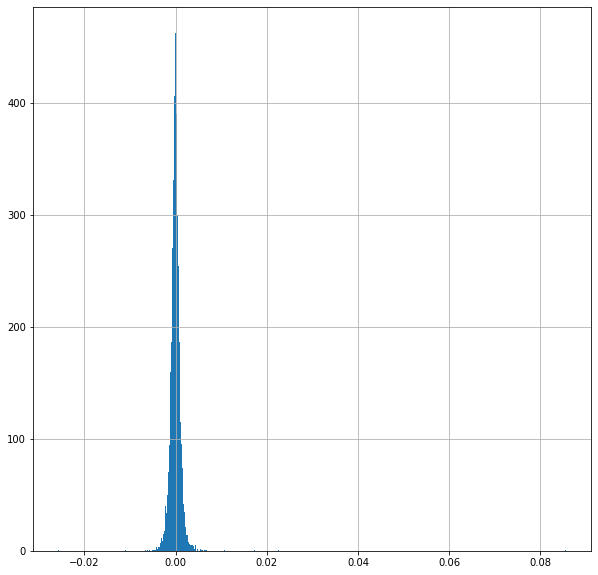

In [24]:
log_returns.PYPL.hist(bins='auto',figsize=(10,10))
plt.show()

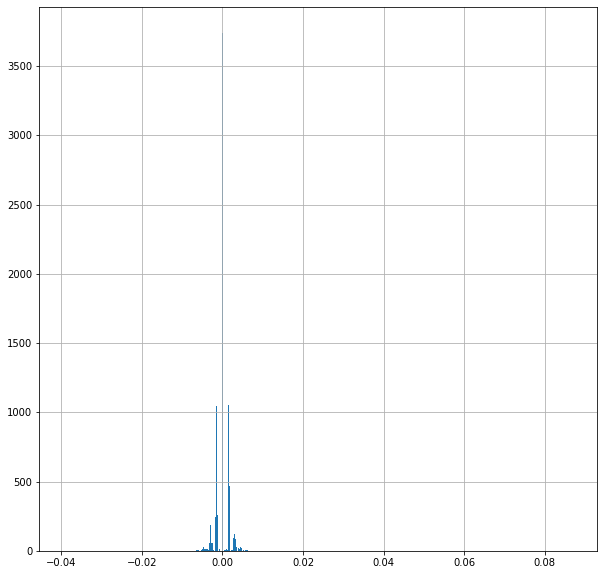

In [25]:
# simple_returns.PBR.hist(bins='auto',figsize=(10,10))
log_returns.PBR.hist(bins='auto',figsize=(10,10))
plt.show()

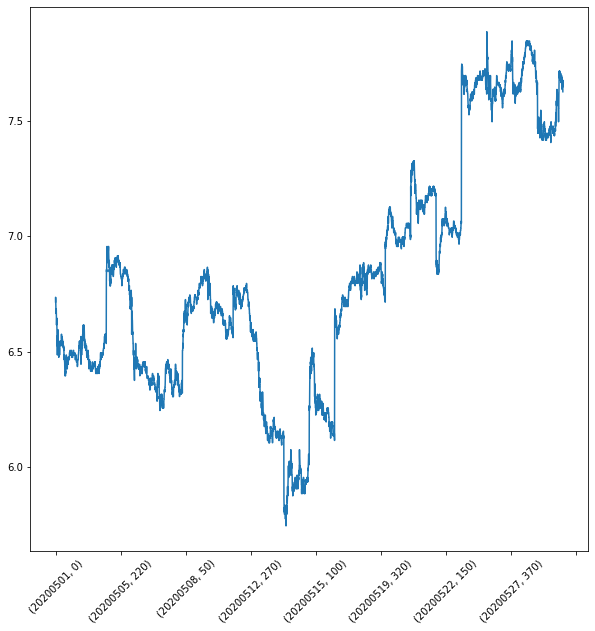

In [42]:
data[data.Ticker=='PBR'].close.plot(figsize=(10,10))
plt.xticks(rotation=45)
plt.show()

In [ ]:
stop

In [15]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
# #                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                       'macd_diff',
#                                                       'macd_signal',
#                                                     'dis5',
#                                                     'dis10',
#                                                       'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 5
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_v9(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,
                                                 ticker_dummies=False)

0
            days  timestamps ticker
0     20200501.0         1.0   AAPL
1     20200501.0         2.0   AAPL
2     20200501.0         3.0   AAPL
3     20200501.0         4.0   AAPL
4     20200501.0         5.0   AAPL
...          ...         ...    ...
7793  20200529.0       384.0   AAPL
7794  20200529.0       385.0   AAPL
7795  20200529.0       386.0   AAPL
7796  20200529.0       387.0   AAPL
7797  20200529.0       388.0   AAPL

[7798 rows x 3 columns]
(7798, 32) (7798, 3) (7798,)
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0         4.0   AAPL
4  20200501.0         5.0   AAPL
5  20200501.0         6.0   AAPL
6  20200501.0         7.0   AAPL
7  20200501.0         8.0   AAPL
8  20200501.0         9.0   AAPL
9  20200501.0        10.0   AAPL
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0    

## Splitting the data

## Adding ticker dummies

In [10]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [11]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0',
       ...
       'd_ticker_SO', 'd_ticker_SRE', 'd_ticker_T', 'd_ticker_TM',
       'd_ticker_TSLA', 'd_ticker_TSM', 'd_ticker_UNP', 'd_ticker_UPS',
       'd_ticker_V', 'd_ticker_WMT'],
      dtype='object', length=126)

## Constructing our final train/validation sets

In [12]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.astype({'days':int,'timestamps':int}).sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

test_index = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].index
test_index = tempIndices.loc[test_index]

train_index = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].index
train_index = tempIndices.loc[train_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(343145, 126)
(343145, 1)
(85745, 126)
(85745, 1)


In [13]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [14]:
{i:colname for i,colname in enumerate(X_train.columns)}

{0: 'open_lag0',
 1: 'high_lag0',
 2: 'low_lag0',
 3: 'close_lag0',
 4: 'spread_open_lag0',
 5: 'spread_high_lag0',
 6: 'spread_low_lag0',
 7: 'spread_close_lag0',
 8: 'bidsize_open_lag0',
 9: 'bidsize_high_lag0',
 10: 'bidsize_low_lag0',
 11: 'bidsize_close_lag0',
 12: 'ofrsize_open_lag0',
 13: 'ofrsize_high_lag0',
 14: 'ofrsize_low_lag0',
 15: 'ofrsize_close_lag0',
 16: 'relReturns_DIA_lag0',
 17: 'relReturns_IDU_lag0',
 18: 'relReturns_IYC_lag0',
 19: 'relReturns_IYE_lag0',
 20: 'relReturns_IYG_lag0',
 21: 'relReturns_IYH_lag0',
 22: 'relReturns_IYJ_lag0',
 23: 'relReturns_IYK_lag0',
 24: 'relReturns_IYM_lag0',
 25: 'relReturns_IYR_lag0',
 26: 'relReturns_IYW_lag0',
 27: 'relReturns_IYZ_lag0',
 28: 'relReturns_QQQ_lag0',
 29: 'relReturns_SPY_lag0',
 30: 'open_lag1',
 31: 'high_lag1',
 32: 'low_lag1',
 33: 'close_lag1',
 34: 'spread_open_lag1',
 35: 'spread_high_lag1',
 36: 'spread_low_lag1',
 37: 'spread_close_lag1',
 38: 'bidsize_open_lag1',
 39: 'bidsize_high_lag1',
 40: 'bidsize_

In [15]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

In [16]:
X_train.iloc[:,0].mean(),X_train.iloc[:,0].std()

(-4.366881544104378e-17, 1.0000014571127978)

In [17]:
X_test.iloc[:,0].mean(),X_test.iloc[:,0].std()

(0.0002332618381423609, 0.9248626061424452)

## Prepping for models

In [18]:
N_VALIDATION = y_test.shape[0] #int(1e3)
N_TRAIN = y_train.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 50

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X_train.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343145, 85745, 428890, 1340, 1311, 67000)

In [19]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16986, 17326, 17371, 17051, 17011], dtype=int64))

In [20]:
y_test

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
85740,0.0
85741,0.0
85742,0.0
85743,0.0


## A Logistic Regression model in TF/Keras

In [21]:
one_hot = True
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

if one_hot:
    y_train_1h = one_hot_encode(y_train.values.astype(np.int), n_classes)
    y_test_1h = one_hot_encode(y_test.values.astype(np.int), n_classes)

In [107]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(5,
                       input_shape=(FEATURES,),
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),#'categorical_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping
             #tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            X_train, #train_features,
                            y_train_1h, #y_train, #train_labels,
                            batch_size=3300, #BATCH_SIZE,
                            epochs=50, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(X_test, y_test_1h),
                            verbose=0) #(val_features, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 635       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.7971,  auc:0.5129,  loss:6.3591,  val_accuracy:0.7987,  val_auc:0.5155,  val_loss:3.4178,  
..................................................

In [108]:
model.evaluate(X_test,  y_test_1h, verbose=2)

2680/2680 - 4s - loss: 1.6030 - accuracy: 0.8001 - auc: 0.5556


[1.6030398607254028, 0.80008864402771, 0.5556111931800842]

In [109]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [110]:
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [111]:
probs= model.predict(X_test, verbose=1)
probs

2680/2680 [==============================] - 2s 570us/step


array([[0.16055223, 0.17828262, 0.21149077, 0.20517822, 0.24449615],
       [0.13443379, 0.16827527, 0.19464992, 0.20581256, 0.29682848],
       [0.15774547, 0.18336804, 0.19854121, 0.20783585, 0.25250944],
       ...,
       [0.19282566, 0.20243613, 0.19358627, 0.20692748, 0.20422454],
       [0.19876043, 0.20451902, 0.19506893, 0.20458971, 0.19706187],
       [0.19003832, 0.19892633, 0.19998339, 0.2013632 , 0.20968874]],
      dtype=float32)

## Update indices of data

In [112]:
X_test.set_index(pd.MultiIndex.from_frame(test_index), inplace=True)
X_train.set_index(pd.MultiIndex.from_frame(train_index), inplace=True)
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL    -0.928467   0.617850 -1.177361    0.665338   
                    ABBV     0.975907   0.649053 -0.354990   -0.370518   
                    ABT     -0.323201   0.337016 -0.275916   -0.371731   
                    AEP     -0.574165   1.351137 -2.458363   -0.431839   
                    AMT      1.330209   1.023498 -5.131070    0.325826   
...                               ...        ...       ...         ...   
20200529 388        TSM      0.267303  -0.084234  0.388307   -0.562972   
                    UNP      0.045864  -0.162244  0.166900   -0.026086   
                    UPS      0.223015  -0.084234  0.293418   -0.340059   
                    V        0.001576  -0.006225  0.214344    0.090200   
                    WMT      0.769231   0.493035  0.340863   -0.232242   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL            0.361580          0.114771   
                    ABBV            0.212871          0.036328   
                    ABT             0.780669          0.418740   
                    AEP             0.631960          1.693447   
                    AMT             2.578697          3.046597   
...                                      ...               ...   
20200529 388        TSM            -0.246775         -0.306862   
                    UNP            -0.179180         -0.218614   
                    UPS            -0.206218         -0.248030   
                    V              -0.152142         -0.218614   
                    WMT            -0.192699         -0.218614   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.211230          -0.134590   
                    ABBV          -0.211230          -0.264928   
                    ABT           -0.211230          -0.004252   
                    AEP            0.362884           0.028332   
                    AMT           -0.125113           1.152496   
...                                     ...                ...   
20200529 388        TSM           -0.211230          -0.297512   
                    UNP           -0.211230          -0.264928   
                    UPS           -0.211230          -0.297512   
                    V             -0.211230          -0.248636   
                    WMT           -0.211230          -0.297512   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.062813          -0.116091  ...   
                    ABBV            -0.193666          -0.193808  ...   
                    ABT             -0.156280          -0.193808  ...   
                    AEP             -0.193666          -0.217124  ...   
                    AMT             -0.174973          -0.217124  ...   
...                                       ...                ...  ...   
20200529 388        TSM             -0.006733          -0.061688  ...   
                    UNP             -0.174973          -0.178265  ...   
                    UPS             -0.193666          -0.178265  ...   
                    V               -0.193666          -0.131634  ...   
                    WMT             -0.156280          -0.209352  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [113]:
preds = pd.DataFrame(model.predict(X_test, verbose=1))
preds
# preds[0] = 1 - preds[1]

2680/2680 [==============================] - 1s 553us/step


,0,1,2,3,4
0,0.160552,0.178283,0.211491,0.205178,0.244496
1,0.134434,0.168275,0.194650,0.205813,0.296828
2,0.157745,0.183368,0.198541,0.207836,0.252509
3,0.127552,0.154199,0.180994,0.201318,0.335937
4,0.239059,0.204421,0.207012,0.184947,0.164561
...,...,...,...,...,...
85740,0.187632,0.197745,0.199743,0.204095,0.210785
85741,0.196702,0.204731,0.194344,0.206372,0.197851
85742,0.192826,0.202436,0.193586,0.206927,0.204225
85743,0.198760,0.204519,0.195069,0.204590,0.197062


In [114]:
preds['class'] = preds.iloc[:,0:5].values.argmax(axis=1)
preds['confidence'] = preds.iloc[:,0:-2].values.max(axis=1)
preds = preds.set_index(X_test.index) #.loc[(20200526,0)]
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.160552  0.178283  0.211491  0.205178  0.244496   
                    ABBV    0.134434  0.168275  0.194650  0.205813  0.296828   
                    ABT     0.157745  0.183368  0.198541  0.207836  0.252509   
                    AEP     0.127552  0.154199  0.180994  0.201318  0.335937   
                    AMT     0.239059  0.204421  0.207012  0.184947  0.164561   
...                              ...       ...       ...       ...       ...   
20200529 388        TSM     0.187632  0.197745  0.199743  0.204095  0.210785   
                    UNP     0.196702  0.204731  0.194344  0.206372  0.197851   
                    UPS     0.192826  0.202436  0.193586  0.206927  0.204225   
                    V       0.198760  0.204519  0.195069  0.204590  0.197062   
                    WMT     0.190038  0.198926  0.199983  0.201363  0.209689   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        4    0.211491  
                    ABBV        4    0.205813  
                    ABT         4    0.207836  
                    AEP         4    0.201318  
                    AMT         0    0.239059  
...                           ...         ...  
20200529 388        TSM         4    0.204095  
                    UNP         3    0.206372  
                    UPS         3    0.206927  
                    V           3    0.204590  
                    WMT         4    0.201363  

[85745 rows x 7 columns]

In [115]:
np.unique(preds['class'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 8881, 18738,  8185, 36082, 13859], dtype=int64))

In [116]:
probs

array([[0.16055223, 0.17828262, 0.21149077, 0.20517822, 0.24449615],
       [0.13443379, 0.16827527, 0.19464992, 0.20581256, 0.29682848],
       [0.15774547, 0.18336804, 0.19854121, 0.20783585, 0.25250944],
       ...,
       [0.19282566, 0.20243613, 0.19358627, 0.20692748, 0.20422454],
       [0.19876043, 0.20451902, 0.19506893, 0.20458971, 0.19706187],
       [0.19003832, 0.19892633, 0.19998339, 0.2013632 , 0.20968874]],
      dtype=float32)

In [117]:
## Setting one day to investigate
temp = preds.loc[20200526,0]

probs = pd.DataFrame(columns=['ticker','prob','class'])
## Adding class 0
probs[['ticker','prob','class']] = temp[temp['class'] == 0][[0,'class']].reset_index().copy(deep=True)
# ## Adding class 4
probs = pd.concat([probs,temp[temp['class'] == 4][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})],
                  axis=0)

# ## Adding other classes - NB: We have randomly selected the probs from columns 4 - we would have chosen any of the columns.
# probs = pd.concat([probs,temp[(temp['class'] != 0)|(temp['class'] != 4)][[4,'class']].reset_index().copy(deep=True)])
probs = pd.concat([probs,
                   temp[~temp['class'].isin([0,4])][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})]).reset_index(drop=True)
# # setting the probs of classes different from 0 and 4 to zero.
probs.loc[~probs['class'].isin([0,4]),'prob'] = 0

# Weights
probs['weight'] = probs.prob / probs.prob.sum()

# directions
probs['direction'] = 0#probs.prob / probs.prob.sum()
probs.loc[probs['class'].isin([0]),'direction'] = -1
probs.loc[probs['class'].isin([4]),'direction'] = 1

probs = probs.sort_values(['class','ticker'])

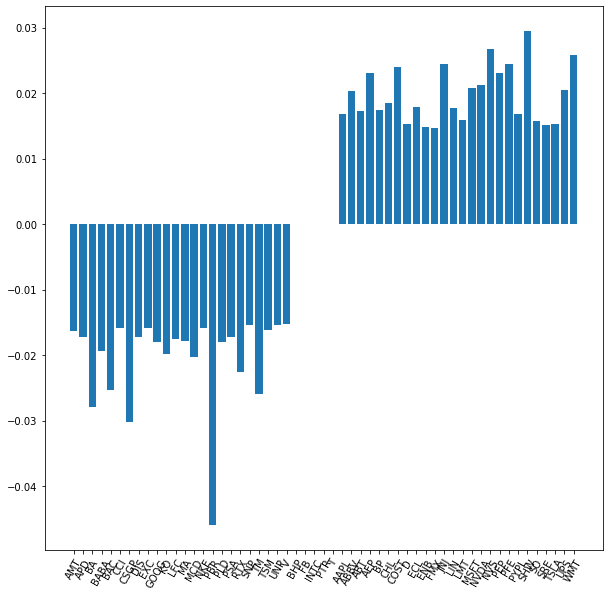

In [118]:
plt.figure(figsize=(10,10))
plt.bar(x = probs.ticker,
        height = probs.weight*probs.direction)
plt.xticks(rotation=60)
plt.show()

In [119]:
probs.prob.sum()

14.596226

In [120]:
probs.weight.sum()

0.99999994

In [121]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

## Introducing the stop-loss / profit-goal option

In [23]:
def returns(price_data,horizon):
    
    return (price_data.values[1:]/price_data.values[0:-1])-1


In [24]:
### Recreating the price series for each tradable ticker
X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
                          if 'd_ticker' in i])

cp_x_train = pd.DataFrame(actual_series_train.T,
                         columns=data.Ticker.unique())


### Recreating the price series for each tradable ticker
X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_test = np.array([X_test_temp[X_test_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

cp_x_test = pd.DataFrame(indexed_series_test.T,
                         columns=data.Ticker.unique())

### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

### Recreating the price series for each ETF

actual_series_etfs = np.array([sector_test[sector_test['Ticker']==i].close.reset_index(drop=True).values\
                          for i in sector_test.Ticker.unique()])

indexed_series_etfs = np.divide(actual_series_etfs,actual_series_etfs.T[0].reshape(-1,1))*100

cp_sector_test = pd.DataFrame(indexed_series_etfs.T,
                         columns=sector_test.Ticker.unique())

## Simple way of calculating the standard deviation over a fixed window
The online optione below can be adjusted based on [this](https://lingpipe-blog.com/2009/07/07/welford-s-algorithm-delete-online-mean-variance-deviation/) reference, to do the same.

In [25]:
horizon = 5

print(cp_x_train.iloc[-horizon:,0:2])
returns_container = returns(cp_x_train.iloc[-(horizon+1):,:],
                            horizon)
max_steps = 0
output_container = np.zeros((max_steps+1,
                             len(data.Ticker.unique())))

output_container[0] = np.std(returns_container,axis=0)
for i,j in enumerate(np.arange(max_steps)):

    returns_container[0:-1] = returns_container[1:]
    print(i)
    if i == 0:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_train.T[-1])-1
    
    else:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_test.T[i-1])-1
    
    output_container[i+1] = np.std(returns_container,axis=0)

         AAPL    ABBV
6234  318.340  91.875
6235  318.475  91.895
6236  318.690  91.970
6237  318.850  91.950
6238  318.850  92.115


## Online standard deviation calculations

In [26]:
def online_std(initial_vals,horizon,new_vals,count=0,m2=0):
    
    ## We take a set of initial values, from which we calculate a running mean
    
    if count == 0:
        count = horizon + 1
        
    else:
        count += 1
    print(count)
    
    updated_vals = initial_vals + ((new_vals[0] - initial_vals) / count)

    m2 = initial_vals*(count-1) + (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)

    return updated_vals,m2,count

def online_std_fixed(old_mean,old_vals,new_vals,horizon):
    
    ## We take a set of initial values, from which we calculate a running mean

    updated_mean = old_mean + ((new_vals - old_vals) / horizon)

    m2 = old_mean*horizon + (new_vals - old_mean)*(new_vals - updated_mean)

    return updated_mean,m2,horizon

In [57]:
os.listdir('../../')

['.git',
 '13-09-2020 backup',
 '15-09-2020 backup',
 '19-09-2020 backup',
 '23-08-2020 bkacup',
 'Aktier juni 2020.txt',
 'Anders møde noter 14-10-2020.txt',
 'backup 10-08-2020',
 'crazy_error.PNG',
 'cross entropy.txt',
 'Daily_TAQ_Client_Spec_v3.0.pdf',
 'NN_model_specifications.txt',
 'predications_13_10_2020.xlsx',
 'Rebalance idea.xlsx',
 'TAQguide_December_2017-3.pdf',
 'Thesis drafts removed from main folder',
 'Thesis_UCPH',
 'timings export experiment data into txt file.txt',
 'TO DO AGREEMENT, 02-06-2020.txt',
 'to do thesis 06-07-2020.txt']

In [62]:
preds = pd.read_excel('../../predications_13_10_2020.xlsx',index_col=[0,1,2])

In [63]:
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.156074  0.196683  0.213549  0.217550  0.216144   
                    ABBV    0.122825  0.204767  0.201979  0.219734  0.250695   
                    ABT     0.150630  0.197960  0.207091  0.218055  0.226265   
                    AEP     0.112675  0.191944  0.197506  0.218872  0.279003   
                    AMT     0.258658  0.197196  0.191741  0.185435  0.166971   
...                              ...       ...       ...       ...       ...   
20200529 388        TSM     0.185668  0.204919  0.199291  0.204997  0.205125   
                    UNP     0.198134  0.201897  0.196641  0.206026  0.197301   
                    UPS     0.192535  0.201888  0.196493  0.207021  0.202063   
                    V       0.200340  0.204227  0.194916  0.203791  0.196725   
                    WMT     0.188347  0.215029  0.192567  0.200107  0.203950   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        3    0.217550  
                    ABBV        4    0.219734  
                    ABT         4    0.218055  
                    AEP         4    0.218872  
                    AMT         0    0.258658  
...                           ...         ...  
20200529 388        TSM         4    0.204997  
                    UNP         3    0.206026  
                    UPS         3    0.207021  
                    V           1    0.204227  
                    WMT         1    0.215029  

[85745 rows x 7 columns]

# Backtest module

In [136]:
'''
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

2) Max_positions: Check if the specified number of max positions results in an uneven split? like max position = 9.
'''


class backtest():
    def __init__(self,
                 X_test,
#                  X_train,
                 data,
                 preds,
                 weight_scheme,
                 rebal_scheme,
                 strategy_scheme,
                 # rebal_init_data,
                 # rebal_last_known_price,
                 # rebal_lookback_horizon,
                 # rebal_risk_aversion,
                 max_steps,
                 max_positions,
                 n_classes,
                 slpg_warning = False,
                 slpg_input = {},
                 return_revealer = 1000,
                 zero_spread = False,
                 verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'

        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.hist_directions = np.zeros((max_steps,len(self.all_tickers)))
        self.hist_prev_weights = np.zeros((max_steps,len(self.all_tickers)))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.strategy_scheme = strategy_scheme
        self.rebal_scheme = rebal_scheme
        self.slpg_warning = slpg_warning
        self.slpg_init_data = slpg_input['init_data']
        self.slpg_last_known_price = slpg_input['last_known_price']
        self.slpg_lookback_horizon = slpg_input['lookback_horizon']
        self.slpg_risk_aversion = slpg_input['risk_aversion']
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.return_revealer = return_revealer
        self.zero_spread = zero_spread
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')

    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        if self.verbose >= 1: print(self.all_tickers,'\n')

        if self.slpg_warning: # slpg: Stop Loss / Profit Goal

            self.returns_container = returns(self.slpg_init_data,#cp_x_train.iloc[-(self.rebal_lookback_horizon+1):,:]
                                        self.slpg_lookback_horizon)

            self.output_container = np.zeros((self.max_steps,
                                         len(self.all_tickers)))

        self.ticker_dict = {i:j for i,j in enumerate(self.all_tickers)}

        if self.verbose >= 1: print('Size of returns container: ', self.returns_container.shape)
            
        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            if self.verbose >= 1: print(ts)
            if self.verbose >= 1: print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]
            
            if self.zero_spread:
                close_info.loc[:,'spread_close'] = 0

            self.update_positions(ts, close_info, ts_preds)#,self.rebal_scheme
            
            ## Print the current portfolio return if the step are in the sequence. 
            if self.t in np.arange(self.return_revealer,self.max_steps+self.return_revealer,self.return_revealer):
                
                print('Step %i - Current return: %.3f'%(self.t,self.hist_rets[self.t,-1]))
            
            self.t += 1

        if self.verbose >= 1: print(f'run function finished at step {self.t}, time: {ts}')

    def update_positions(self, ts, close_info, ts_preds):#,rebal_scheme
        
#         if self.t >= 291:
#             self.verbose = 1

        # Long positions
        long_pos = ts_preds[ts_preds['class'] == (self.n_classes - 1)].sort_values('confidence',
                                                                                   ascending=False)
        # Short positions
        short_pos = ts_preds[ts_preds['class'] == 0].sort_values('confidence',ascending=False)

        # The choice of strategy scheme determines the actions going forward
        if self.strategy_scheme == 'max_pos':

            ## Open all available long positions if the number of available long positions are less than the
            ## intended number of long positions.
            if (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.index.values

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_list)+\
                                                                                                                len(short_list),self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
                short_list = short_pos.iloc[0:int(self.max_positions/2),:].index.values

            ## If there are less long and excess short positions:
            elif (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions-short_pos.shape[0]),:].index.values
                short_list = short_pos.index.values

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        ## If "None" strategy scheme is chosen, all candicates are chosen.
        elif self.strategy_scheme == None:

            long_list = long_pos.index.values
            short_list = short_pos.index.values

        ## Else return eror
        else:

            raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # check if any new positions are made
        new_long = long_list[~np.isin(long_list, self.open_long_positions)]
        new_short = short_list[~np.isin(short_list, self.open_short_positions)]

        ###### check if any needs closed before we determine if any new ones should be
        ###### disregarded.

        ## Closing those that have changed signal.
        close_long = list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
        close_short = list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])

        ## Meant to check if time to close positions due to stop loss or profit goal.
        ## However, at the moment we just inform about positions that exceeds either of the thresholds.
        if (self.t > 0) & (self.slpg_warning):

            positions_above_pg = np.where(self.hist_rets[self.t-1][0:-1]>(1+self.output_container[self.t-1]*self.slpg_risk_aversion[1]))[0]
            positions_below_sl = np.where(self.hist_rets[self.t-1][0:-1]<(1+self.output_container[self.t-1]*self.slpg_risk_aversion[0]*-1))[0]

            print('Number of positions above profit goal: ',len(positions_above_pg))

            if len(positions_above_pg) > 0:
                print('Positionns exceeding the profit goal: ',[(self.ticker_dict[i],i) for i in positions_above_pg],'\n')

            print('Number of positions below stop loss: ',len(positions_below_sl))

            if len(positions_below_sl) > 0:
                print('Positionns exceeding the stop loss: ',[(self.ticker_dict[i],i) for i in positions_below_sl])

        if self.verbose >= 1:
            print(f'\nclose_long: {close_long}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_long]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.strategy_scheme == 'max_pos':

            long_candidates = self.open_long_positions+list(new_long)
            short_candidates = self.open_short_positions+list(new_short)

            ## Checking if any of the new candidates should be included or any of the existing should be closed
            ## at the expense of a new.
            if (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) <= (self.max_positions / 2)):

                # Do nothing, sticking with the generated list, consisting of open positions and new buys!
                pass

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_candidates)+\
                                                                                                                len(short_candidates),
                                                                                                                 self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (len(long_candidates) > (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ### Prepping the candidates
                temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values
                temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                # Determining the ranking of the new candidates
                new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]
                new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                # Determining the ranking of the existing positions
                open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]
                open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                # if some new buy candidates have a ranking that is outside the desired long positions,
                # we diregard that new buy.
                if len(new_long_ranking) > 0:
                    if (max(new_long_ranking) > ((self.max_positions / 2) - 1)):
                        new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if len(new_short_ranking) > 0:
                    if (max(new_short_ranking) > ((self.max_positions / 2) - 1)):
                        new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                ## we close it.
                if len(open_long_ranking) > 0:
                    if (max(open_long_ranking) > ((self.max_positions / 2) - 1)):
                        self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if len(open_short_ranking) > 0:
                    if (max(open_short_ranking) > ((self.max_positions / 2) - 1)):
                        self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]

            ## If there are less long and excess short positions:
            elif (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ## With less long candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a buy signal anymore but then they are dropped above,
                ## and new ones should be added.
                ## For the sell candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.

                if len(short_candidates) >= (self.max_positions - len(long_candidates)):

                    temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                    # Determining the ranking of the existing positions
                    open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if len(new_short_ranking) > 0:
                        if (max(new_short_ranking) > ((self.max_positions / 2) - 1)):
                            new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
#                     try:
                    if len(open_short_ranking) > 0:
                        if (max(open_short_ranking) > ((self.max_positions / 2) - 1)):
                            self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                            close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]
#                     except:
#                         print('Step:\n\n'self.t,'\n')
#                         print('open short positions:\n\n',self.open_short_positions,'\n')

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                ### Vice versa, compared to the if statement just above.

                ## With less sell candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a sell signal anymore but then they are dropped below,
                ## and new ones should be added.

                ## For the short candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.
                if len(long_candidates) >= (self.max_positions - len(short_candidates)):

                    temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]

                    # Determining the ranking of the existing positions
                    open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if len(new_long_ranking) > 0:
                        if (max(new_long_ranking) > ((self.max_positions / 2) - 1)):
                            new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
                    if len(open_long_ranking) > 0:
                        if (max(open_long_ranking) > ((self.max_positions / 2) - 1)):
                            self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                            close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'new_long: {new_long}')
            print(f'new_short: {new_short} \n')

        self.open_long_positions += [long_i for long_i in new_long]
        self.open_short_positions += [short_i for short_i in new_short]

        #self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')
        
        ########## Calculating returns ##########
        
        if self.t > 0:
            
            if self.verbose >= 1: print('self.prev_close.direction new step:\n\n',self.prev_close.direction,'\n')
                
#             print('\nIndex 37 direction before return calculation: ',self.prev_close.iloc[37, 1],'\n')
            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction'] = -1
#             print('\nIndex 37 direction, before return but after adjustment: ',self.prev_close.iloc[37, 1],'\n')
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
            
#             print('Current ret, index 37: ',current_ret[37],'\n')
            
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_long)
            
#             print('\nIndex 37: ',boolcousin[37],'\n')
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values - 1
            
            ## We multiply with the opposite direction to get the correct return.
            current_ret[boolcousin] = (current_ret[boolcousin] * -self.prev_close[boolcousin].direction.values) + 1
            
#             print('portfolio return, accumulated, before:\n\n',current_ret.sum()*self.hist_rets[self.t - 1, -1],'\n')
#             print('Current ret with bool cousin, index 37: ',current_ret[37],'\n')
#             print('Prev close: \n\n',self.prev_close)
            ## Correcting the return of those we rebalance
            #self.prev_close.direction.values != 0&
#             rebal_mask = (self.prev_close.direction.values != 0)&(~(np.isin(self.all_tickers,new_long)|\
#                             np.isin(self.all_tickers,new_short)|np.isin(self.all_tickers,close_long)|
#                             np.isin(self.all_tickers,close_short)))
            
            # Preparing the generation of the new weights
            future_direction = self.prev_close.direction.copy(deep=True)
            
            if self.verbose >= 1: print('future_direction 1:\n\n',future_direction,'\n')
            
            # set directions == 0 for closed positions
            future_direction[np.isin(self.all_tickers, close_long)] = 0
            future_direction[np.isin(self.all_tickers, close_short)] = 0            
            
            if self.verbose >= 1: print('future_direction 2:\n\n',future_direction,'\n')
            
            # update directions for new positions
            future_direction[np.isin(self.all_tickers, new_long)] = 1
            future_direction[np.isin(self.all_tickers, new_short)] = -1
            
            if self.verbose >= 1: print('future_direction 3:\n\n',future_direction,'\n')
            if self.verbose >= 1: print('future_direction 3 abs:\n\n',future_direction.abs(),'\n')
            if self.verbose >= 1: print('future_direction 3 abs-sum:\n\n',future_direction.abs().sum(),'\n')
        
            if self.weight_scheme == 'constant':
                
                # Set new weights
                new_weights = (1/future_direction.abs().sum())*future_direction.abs()

            elif self.weight_scheme == 'prob':
#                 print('Predictions: \n',ts_preds,'\n')
                new_weights = ((ts_preds.confidence)*future_direction.abs())/((ts_preds.confidence)*future_direction.abs()).sum()

            if self.verbose >= 1: print('New weights:\n\n',new_weights,'\n')
            if self.verbose >= 1: print('noob')
            
            if self.verbose >= 1: print('previous weights:\n\n',self.hist_prev_weights[self.t - 1],'\n')
            
            portfolio_dev = current_ret * self.hist_prev_weights[self.t - 1,:]
            
            if self.verbose >= 1: print('portfolio development, before correction:\n\n',portfolio_dev,'\n')
            
            portfolio_share = portfolio_dev / sum(portfolio_dev)
            
            if self.verbose >= 1: print('portfolio share:\n\n',portfolio_share,'\n')
            
            correction = np.zeros(len(portfolio_share))
            
            if self.verbose >= 1: print('correction mask:\n\n',(new_weights != 0)&(self.hist_directions[self.t - 1]==future_direction),'\n')
            
            correction_mask = ((new_weights != 0)&(self.hist_directions[self.t - 1]==future_direction)).values
            
            correction[correction_mask] = new_weights[correction_mask] / portfolio_share[correction_mask] - 1
            
            if self.verbose >= 1: print('correction:\n\n',correction,'\n')
            
            share_to_keep = 1-abs(correction)
            share_to_correct = abs(correction)
            if self.verbose >= 1: print('share_to_keep: \n\n',share_to_keep,'\n')
            
#             print(share_to_keep.shape,current_ret.shape,correction_mask.shape)
#             print('rebal_mask:\n\n',rebal_mask,'\n')
#             print('correction_mask:\n\n',correction_mask,'\n')
            
            if self.verbose >= 1: print('return of share to keep:\n\n',share_to_keep[correction_mask] * current_ret[correction_mask],'\n')
            if self.verbose >= 1: print('return of share to correct:\n\n',share_to_correct[correction_mask] * ((close_info[correction_mask].close.values\
                                                             *abs(self.prev_close[correction_mask].direction.values)\
                                                             +(close_info[correction_mask].spread_close.values / 2)\
                                                             *-1*self.prev_close[correction_mask].direction.values)\
                                                            /self.prev_close[correction_mask].prev_close.values),'<n')
            current_ret[correction_mask] =  share_to_keep[correction_mask] * current_ret[correction_mask] +\
                                            share_to_correct[correction_mask] * ((close_info[correction_mask].close.values\
                                                             *abs(self.prev_close[correction_mask].direction.values)\
                                                             +(close_info[correction_mask].spread_close.values / 2)\
                                                             *-1*self.prev_close[correction_mask].direction.values)\
                                                            /self.prev_close[correction_mask].prev_close.values)#- 1
            
            if self.verbose >= 1: print('return after: \n\n',current_ret[correction_mask],'\n')
            
            portfolio_dev[correction_mask] = current_ret[correction_mask] * self.hist_prev_weights[self.t - 1,correction_mask]
            
            if self.verbose >= 1: print('portfolio development, after correction:\n\n',portfolio_dev,'\n')
            
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
            current_ret[self.prev_close.direction.values == 0] = 1
            
            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]
            
            # update total portfolio returns for open positions
#             self.hist_rets[self.t, -1] = (1+sum(((current_ret*self.prev_close.direction.abs().values) - 1)*self.hist_prev_weights[self.t - 1])) * self.hist_rets[self.t - 1, -1]
            
            self.hist_rets[self.t, -1] = sum(portfolio_dev)*self.hist_rets[self.t-1, -1]
        
            if self.verbose >= 1: print('portfolio return, accumulated, after:\n\n',self.hist_rets[self.t, -1],'\n')
            
            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0            
            
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1

            if self.slpg_warning:
                ## Roll back return matrix, to make room to the return coming in at the end of the period.
                self.returns_container[0:-1] = self.returns_container[1:]

                ## Include the new return.
                self.returns_container[-1] = (close_info.close.values/self.prev_close.prev_close)-1

                ## Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            ## Updating the last seen price
            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            ## Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            ## Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2
            overlap = []
#             print(np.isin(new_long,close_long))
#             print(close_long)
            overlap += list(np.array(close_long)[np.isin(close_long, new_long)])
            if len(overlap) > 0:
                print('New longs in close long: ', overlap)

            overlap += list(np.array(new_long)[np.isin(new_long, close_long)])
            if len(overlap) > 0:
                print('Close longs in new long: ', overlap)

            overlap += list(np.array(close_short)[np.isin(close_short, new_short)])
            if len(overlap) > 0:
                print('New shorts in close short: ', overlap)

            overlap += list(np.array(new_short)[np.isin(new_short, close_short)])
            if len(overlap) > 0:
                print('Close shorts in new short: ', overlap)

            if len(overlap) > 0:
                print('######### Overlap between the new candidates and the close candidates #########')

#             # set directions == 0 for closed positions
#             self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
#             self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0
            
            ## Setting the weights for the open positions in the next period.
            if self.weight_scheme == 'constant':
                
                # Set new weights
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()

            elif self.weight_scheme == 'prob':

                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)

        else:

            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            
            ## Initializing the weights
            if self.weight_scheme == 'constant':
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()

            elif self.weight_scheme == 'prob':

                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()

            if self.slpg_warning:

                ## Place to update returns in the returns container
                # Roll back the returns one period
                self.returns_container[0:-1] = self.returns_container[1:]

                # Include the new return
                self.returns_container[-1] = (close_info.close.values/self.slpg_last_known_price)-1

                # Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)

######### A little initialization ###########
max_steps = 1559
slpg_lookback_horizon = 10
slpg_init_data = cp_x_train.iloc[-(slpg_lookback_horizon+1):,:]
slpg_last_known_price = cp_x_train.iloc[-1,:].T

slpg_input = {'init_data':slpg_init_data,
              'last_known_price':slpg_last_known_price,
              'lookback_horizon':slpg_lookback_horizon,
              'risk_aversion':(2,4)}

backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = 'prob',
                        rebal_scheme = 'slpg',
                        strategy_scheme = 'max_pos',### Options: 'max_pos',None
#                         rebal_init_data = rebal_init_data,
#                         rebal_last_known_price = rebal_last_known_price,
#                         rebal_lookback_horizon = rebal_lookback_horizon,
#                         rebal_risk_aversion = (2,4),
                        max_steps=max_steps,
                        max_positions = 5,
                        n_classes=5,
                        slpg_warning = False,
                        slpg_input = slpg_input,
                        return_revealer = 1,
                        zero_spread = False,
                        verbose=False)
start = time.time()
backtest_obj.run()
end = time.time()
print('Processing time : %.3f minutes' %((end-start)/60))
print('final return: %.3f' % backtest_obj.hist_rets[-1,-1])

Step 1 - Current return: 0.994
Step 2 - Current return: 0.991
Step 3 - Current return: 0.987
Step 4 - Current return: 0.984
Step 5 - Current return: 0.984
Step 6 - Current return: 0.982
Step 7 - Current return: 0.981
Step 8 - Current return: 0.979
Step 9 - Current return: 0.976
Step 10 - Current return: 0.975
Step 11 - Current return: 0.975
Step 12 - Current return: 0.972
Step 13 - Current return: 0.971
Step 14 - Current return: 0.970
Step 15 - Current return: 0.969
Step 16 - Current return: 0.968
Step 17 - Current return: 0.966
Step 18 - Current return: 0.966
Step 19 - Current return: 0.964
Step 20 - Current return: 0.962
Step 21 - Current return: 0.960
Step 22 - Current return: 0.958
Step 23 - Current return: 0.958
Step 24 - Current return: 0.956
Step 25 - Current return: 0.955
Step 26 - Current return: 0.954
Step 27 - Current return: 0.953
Step 28 - Current return: 0.953
Step 29 - Current return: 0.952
Step 30 - Current return: 0.950
Step 31 - Current return: 0.948
Step 32 - Current

KeyboardInterrupt: 

In [123]:
(end-start)/60

3.7767587820688884

In [124]:
print('Processing time : %.3f minutes' %((end-start)/60))
print('final return: %.3f' % backtest_obj.hist_rets[-1,-1])

Processing time : 3.777 minutes
final return: 1.326


In [125]:
preds.index.get_level_values(0).unique(),preds.index.get_level_values(1).unique()

(Int64Index([20200526, 20200527, 20200528, 20200529], dtype='int64', name='days'),
 Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             380, 381, 382, 383, 384, 385, 386, 387, 388, 389],
            dtype='int64', name='timestamps', length=390))

In [126]:
3*390+389

1559

In [127]:
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.160552  0.178283  0.211491  0.205178  0.244496   
                    ABBV    0.134434  0.168275  0.194650  0.205813  0.296828   
                    ABT     0.157745  0.183368  0.198541  0.207836  0.252509   
                    AEP     0.127552  0.154199  0.180994  0.201318  0.335937   
                    AMT     0.239059  0.204421  0.207012  0.184947  0.164561   
...                              ...       ...       ...       ...       ...   
20200529 388        TSM     0.187632  0.197745  0.199743  0.204095  0.210785   
                    UNP     0.196702  0.204731  0.194344  0.206372  0.197851   
                    UPS     0.192826  0.202436  0.193586  0.206927  0.204225   
                    V       0.198760  0.204519  0.195069  0.204590  0.197062   
                    WMT     0.190038  0.198926  0.199983  0.201363  0.209689   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        4    0.211491  
                    ABBV        4    0.205813  
                    ABT         4    0.207836  
                    AEP         4    0.201318  
                    AMT         0    0.239059  
...                           ...         ...  
20200529 388        TSM         4    0.204095  
                    UNP         3    0.206372  
                    UPS         3    0.206927  
                    V           3    0.204590  
                    WMT         4    0.201363  

[85745 rows x 7 columns]

In [128]:
preds.loc[20200529,389]

KeyError: 389

In [129]:
preds.shape

(85745, 7)

In [130]:
pot_returns = backtest_obj.hist_rets

### Storing returns in PD
pot_returns_pd = pd.DataFrame(pot_returns,columns = np.concatenate([data.Ticker.unique(),['Portfolio']]))

ticker_dict = {j:i for i,j in enumerate(pot_returns_pd.columns)}
ticker_dict

{'AAPL': 0,
 'ABBV': 1,
 'ABT': 2,
 'AEP': 3,
 'AMT': 4,
 'APD': 5,
 'BA': 6,
 'BABA': 7,
 'BAC': 8,
 'BHP': 9,
 'BP': 10,
 'CCI': 11,
 'CHL': 12,
 'COST': 13,
 'CSGP': 14,
 'D': 15,
 'DIS': 16,
 'ECL': 17,
 'ENB': 18,
 'EXC': 19,
 'FB': 20,
 'FMX': 21,
 'GOOG': 22,
 'INTC': 23,
 'JNJ': 24,
 'KO': 25,
 'LFC': 26,
 'LIN': 27,
 'LMT': 28,
 'MA': 29,
 'MCD': 30,
 'MSFT': 31,
 'NKE': 32,
 'NVDA': 33,
 'NVS': 34,
 'PBR': 35,
 'PEP': 36,
 'PFE': 37,
 'PLD': 38,
 'PSA': 39,
 'PTR': 40,
 'PYPL': 41,
 'RTX': 42,
 'SHW': 43,
 'SNP': 44,
 'SO': 45,
 'SRE': 46,
 'T': 47,
 'TM': 48,
 'TSLA': 49,
 'TSM': 50,
 'UNP': 51,
 'UPS': 52,
 'V': 53,
 'WMT': 54,
 'Portfolio': 55}

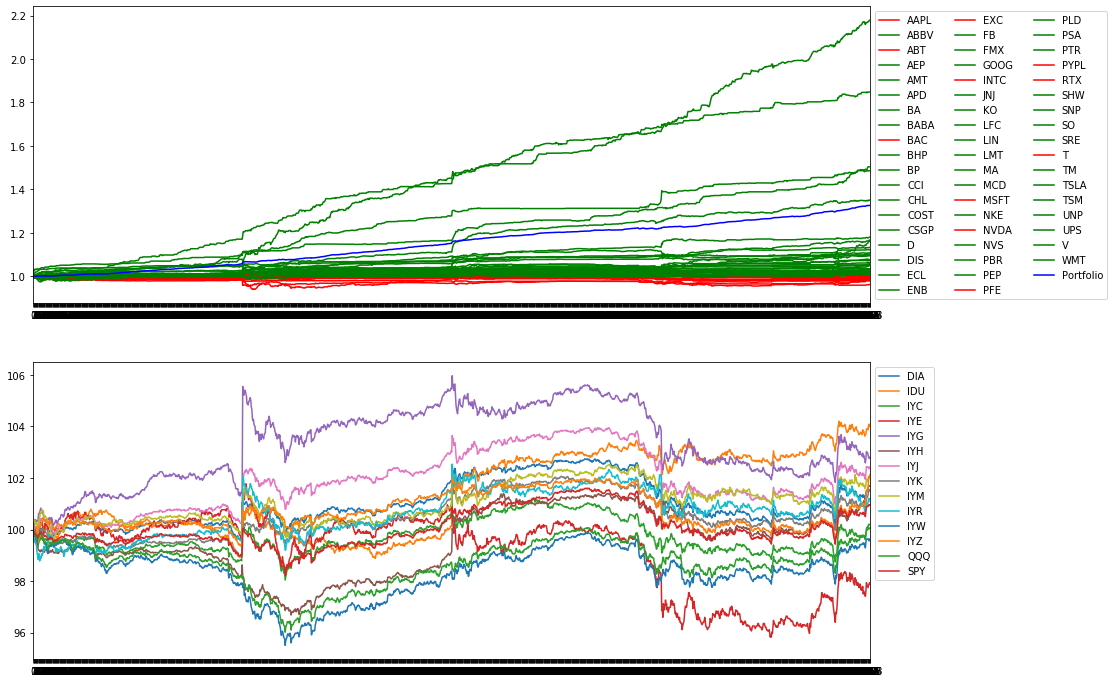

In [131]:
pnl_color = [('r' if pot_returns_pd.iloc[-1,i]<1 else 
             ('gray' if pot_returns_pd.iloc[-1,i]==1 else 
             'g')) for i in np.arange(pot_returns_pd.shape[1]-1)]
pnl_color += ['blue']

## True if plotting against ETFS of sectors and markets, else against tickers.
plot_against_market = True

### Tickers to investigate
## Either a list of tickers or None
tickers_to_plot = None#None['NVDA','BA']

### Setting up the subplot
fig,ax = plt.subplots(2,1,figsize=(15,12))

### Plotting the obtained returns
if tickers_to_plot is not None:
    ticker_location = [ticker_dict[i] for i in tickers_to_plot]
    pot_returns_pd.iloc[:,ticker_location].plot(color=np.array(pnl_color)[ticker_location],ax=ax[0])#.reshape(-1,50)#c=np.array(pnl_color[0:3])
else:
    pot_returns_pd.iloc[:,].plot(color=pnl_color,ax=ax[0])
ax[0].legend(ncol=3,
             bbox_to_anchor=[1,1])
ax[0].set_xticks(np.arange(max_steps))

### Plotting the actual price development

# Against the market
if plot_against_market:
    cp_sector_test.iloc[0:pot_returns_pd.shape[0],].plot(ax=ax[1])
else:
    if tickers_to_plot is not None:
        
        ticker_location = [ticker_dict[i] for i in tickers_to_plot]
        cp_x_test.iloc[0:pot_returns_pd.shape[0],ticker_location].plot(color='black',
                                                   ax=ax[1],legend=None)
    else:
        cp_x_test.iloc[0:pot_returns_pd.shape[0],].plot(color='black',
                                                   ax=ax[1],legend=None)
ax[1].legend(bbox_to_anchor=[1,1])
ax[1].set_xticks(np.arange(max_steps))

plt.show()

In [132]:
#pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])].to_excel('../../pot_returns_1.xlsx')#pot_returns_pd.sum()!=max_steps
pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])]

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT,Portfolio
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997854,0.997374,0.998173,0.999686,1.001792,1.000417,0.998475,1.001915,0.996927,1.000000,...,0.996716,1.000000,0.999779,0.998151,1.000682,0.999482,0.997754,1.001840,0.998203,0.999707
2,0.996418,0.998124,0.992905,0.997112,0.999266,0.999916,0.997571,1.001915,0.997346,0.999605,...,0.994659,0.999226,1.000833,0.995225,1.000682,1.001810,0.996223,1.001429,0.998682,0.999763
3,0.996357,0.998124,0.991185,0.996861,0.993870,0.998216,0.997442,1.002231,0.997346,1.000570,...,0.992879,1.000522,0.999248,0.995297,1.000682,1.003794,1.000868,1.001429,0.998682,1.000200
4,0.996357,0.998124,0.990701,0.996861,0.992193,0.999902,0.998163,1.002208,0.999018,1.000570,...,0.993156,1.000522,1.000874,0.997055,1.003609,1.003971,1.000345,0.999297,0.999041,1.000753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,0.987355,1.024594,0.985582,1.026861,1.132290,1.094953,1.099857,1.048759,0.997274,1.019561,...,1.101411,0.980648,1.484402,1.013848,1.023221,1.030104,1.009079,1.019206,1.022535,1.325454
1555,0.986876,1.024594,0.983665,1.028482,1.132290,1.093986,1.098989,1.050715,0.997274,1.019561,...,1.101411,0.980648,1.485403,1.012388,1.023221,1.030104,1.009079,1.019570,1.022535,1.325714
1556,0.986103,1.024195,0.983501,1.028482,1.132190,1.093914,1.098649,1.051756,0.998099,1.019561,...,1.101411,0.980648,1.485874,1.012873,1.022816,1.029892,1.009079,1.019570,1.022535,1.325858
1557,0.988005,1.024912,0.981107,1.028482,1.131436,1.094568,1.099479,1.053028,0.998099,1.019561,...,1.101411,0.980648,1.486051,1.010991,1.022816,1.029892,1.009079,1.019882,1.022535,1.325961


In [90]:
# Directions
#pd.DataFrame(backtest_obj.hist_directions,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../direction_1.xlsx')

In [86]:
#pd.DataFrame(actual_series_test.T,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../prices_1.xlsx')

In [77]:
 # Save the directions
sum(np.abs(backtest_obj.hist_directions))!=0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [46]:
### Recreating the price series for each tradable ticker
# X_test_tempa = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_spread_test = np.array([X_test_temp[X_test_temp[i]==1].spread_close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
# indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

spread_x_test = pd.DataFrame(actual_series_spread_test.T,
                             columns=data.Ticker.unique())

In [87]:
spread_x_test.loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../spreads_1.xlsx')

In [48]:
preds.to_excel('../../predications_13_10_2020.xlsx')

In [117]:
X[(X.d_ticker_APD==1)&(tempIndices.days>=tempIndices.days.unique()[first_val_day])]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
45229,-3.005,0.080,-3.005,239.555,9.08,9.08,0.63,0.79,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45230,0.110,1.475,-0.670,239.455,0.77,4.35,0.03,4.35,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45231,-0.570,1.130,-0.665,239.335,2.97,2.97,0.31,1.15,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45232,-0.255,0.790,-0.255,239.790,1.55,2.70,0.56,0.56,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45233,0.430,0.435,-0.240,239.385,0.51,1.06,0.04,0.55,1.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46783,-0.125,0.220,-0.385,242.190,0.15,1.74,0.03,1.60,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
46784,-0.510,0.035,-0.700,242.455,1.11,1.60,0.07,0.15,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
46785,-0.065,0.000,-0.285,242.505,0.12,0.44,0.04,0.21,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
46786,0.135,0.320,-0.125,242.360,0.23,0.54,0.06,0.38,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sectorETFS.reset_index()

In [ ]:
tempIndices

In [ ]:
### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
# X_train = [tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

sector_test

In [ ]:
price_candles

In [ ]:
indices

In [ ]:
temp_sectorIndices

In [ ]:
# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

In [ ]:
cp_x_test

In [ ]:
pot_returns_pd

In [ ]:
'''
            OLD VERSION
            
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

'''


class backtest():
    def __init__(self, X_test, data, preds, weight_scheme, max_steps, max_positions, n_classes,verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'
        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')



    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            #print(ts_data)

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]

            self.update_positions(ts, close_info, ts_preds)

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

        #for ts in unique_timesteps[:2]:

        # for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
        #     #print(i)
        #     ts_data = data.loc[(ts[0], ts[1])]
        #     if ts_data.shape == 0:
        #         pass
        #         #print(i, 'hovhov')


    def update_positions(self, ts, close_info, ts_preds):

        #print(ts_preds, '\n')

        # use predictions to select what to hold
        long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
        short_list = ts_preds[ts_preds['class'] == 0].index.values

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # if any open positions
        # if (len(self.open_long_positions) > 0) or (len(self.open_short_positions) > 0):


        # check if any new positions are made
        new_buy = long_list[~np.isin(long_list, self.open_long_positions)]
        new_sell = short_list[~np.isin(short_list, self.open_short_positions)]




#         print(self.ticker_dict)
#             self.hist_rets

        if self.verbose >= 1:
            print(f'new_buy: {new_buy}')
            print(f'new_sell: {new_sell} \n')

        self.open_long_positions += [long_i for long_i in new_buy]
        self.open_short_positions += [short_i for short_i in new_sell]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#             print(self.open_long_positions,'\n') #[~np.isin(self.open_long_positions, long_list)])
#             print(np.isin(self.open_long_positions, long_list),'\n')
#             print(long_list,'\n')

        # check if any are closed
        close_buy = np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)]
        close_short = np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)]

        if self.verbose >= 1:
            print(f'close_buy: {close_buy}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_buy]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

#             print(close_info.close.values[21])
#             print(close_info.spread_close.values[21])
#             print(self.prev_close.direction.values[21])
#             print('Close prices: \n\n',close_info.close.values)
            # * self.prev_close.direction.values\
            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
#             print(self.all_tickers,'\n')
#             print(current_ret,'\n')
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_buy)
#             print(self.all_tickers[boolcousin],'\n')
#             print(close_info[boolcousin].close.values,'\n')
#             print(close_info[boolcousin].spread_close.values,'\n')
#             print(self.prev_close[boolcousin].direction.values,'\n')
#             print((close_info[boolcousin].close.values\
#                                                                  *abs(self.prev_close[boolcousin].direction.values)\
#                                                                  +(close_info[boolcousin].spread_close.values / 2)\
#                                                                  *self.prev_close[boolcousin].direction.values))
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values
#             print(current_ret)
#             print(self.prev_close.direction.values)
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
#             current_ret[current_ret == 0] = 1
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
#             print(current_ret)
#             print((current_ret-1)[current_ret!=0])
#             current_ret[self.prev_close.direction.values == 0] = 0

            ## if the weights should be based on the probabilities and their distribution.
#             if self.weight_scheme == 'prob_dist':

#             ## if the weights should be based on the probabilities and equally distributed between long and short positions.
#             elif self.weight_scheme == 'prob_equal':

#             else:

            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
            
            
        
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1
            
#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            
#             print('Spread:\n\n',close_info.spread_close)
#             print('Corrected Prices:\n\n',self.prev_close)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:



            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1


#             self.ticker_dict = {j:[close_info.iloc[i,0], 1, 0] if j in new_buy \
#                                 else j:[close_info.iloc[i,0], -1, 0] if j in new_sell \
#                                 else j:[close_info.iloc[i,0], 0, 0] \
#                                     for i,j in enumerate(close_info.Ticker)}

#             self.ticker_dict = {j.Ticker:[j.close, 1, 0] if j in new_buy \
#                                 else j.Ticker:[j.close, -1, 0] if j in new_sell \
#                                 else j.Ticker:[j.close, 0, 0] \
#                                     for i,j in enumerate(close_info.iterrows())}

#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
#             print(self.prev_close)

#         print(close_info.close.copy(deep=True).values)

#         self.prev_close.loc[:,'prev_close'] = close_info.close.values

#         print(close_info.close.copy(deep=True).values)

        #print(self.prev_close.loc[:,'prev_close'])


backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        max_steps=50,
                        max_positions = 10,
                        n_classes=5)
backtest_obj.run()


In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:]

In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:].astype(str).to_csv('tabledata.csv')

In [ ]:
data.sort_index().loc[(20200526,0)].reset_index().loc[21]

In [ ]:
data.sort_index().loc[(20200526,1)].reset_index().loc[21]

In [ ]:
data[data.Ticker=='AAPL']

In [ ]:
[i for i in backtest_obj.hist_rets[1]]

In [ ]:
backtest_obj.prev_close

In [ ]:
data.sort_index()

In [ ]:
print("Keras version:", keras.__version__)

In [ ]:
preds

In [ ]:
data

In [ ]:
ts_preds = preds.loc[(20200526, 0)]
ts_preds[ts_preds['class'] == 1].index.values

In [ ]:
long_list = ts_preds[ts_preds['class'] == 1].index.values
short_list = ts_preds[ts_preds['class'] == 0].index.values

print(long_list, short_list,'\n\n')

open_long_positions = ['AAPL','ABT']
open_short_positions = ['BAC','KO']

# check if any new positions are made
# if any open positions
if (len(open_long_positions) > 0) or (len(open_short_positions) > 0):
    new_buy = long_list[~np.isin(long_list, open_long_positions)]
    new_short = short_list[~np.isin(short_list, open_short_positions)] 
    
new_buy, new_short

In [ ]:
open_long_positions[int(~np.isin(open_long_positions, long_list))]

In [ ]:
~np.isin(open_long_positions, long_list)

In [ ]:
# check if any are closed
close_buy = open_long_positions[~np.isin(open_long_positions, long_list)] 
close_short = open_short_positions[~np.isin(open_short_positions, short_list)] 

In [ ]:
np.isin(long_list, open_long_positions, invert=True)

In [ ]:
for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
    #print(i)
    ts_data = data.loc[(ts[0], ts[1])]
    if ts_data.shape == 0:
        pass

In [ ]:
ts_data[['close','spread_close']]

In [ ]:
#tmp = [(i,j) for i,j in zip(X_test.index.get_level_values(0),X_test.index.get_level_values(1))]

X_test.reset_index().groupby(['days','timestamps']).size()


#np.unique(X_test.index.get_level_values(1))

In [ ]:
# 20200526  0
X_test

In [ ]:
np.unique(X_test.index.get_level_values(1))

In [ ]:
hej = np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                              for j in np.unique(X_test.index.get_level_values(0))])
hej

In [ ]:
def t1():
    for i in hej[:]:
        #print(i)
        try:
            timestep_data = X_test.loc[(i[1], i[0])]
        except:
            pass
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
def t2():
    for i in X_test.reset_index().groupby(['days','timestamps']).size().index[:]:
        #print(i)
        timestep_data = X_test.loc[(i[0], i[1])]
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
%timeit t1()
%timeit t2()

In [ ]:
X_test

In [ ]:
np.unique(( X_test.index.get_level_values(0).values, X_test.index.get_level_values(1).values ))